In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import os
import _pickle as cPickle
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np
from torchvision.models import ResNet50_Weights

torch.set_default_device('cpu') 
device = torch.device('cuda:0')

IMAGENET_PATH = "../data/Imagenet32_val/"
PATH = "../2.NeuralHashing/mainModel.pth"
HASH_SIZE = 64

In [29]:
print(torch.__version__)

2.4.1+cu124


In [30]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'val_data')

    dict_ = unpickle(data_file) #+ str(idx))

    images = dict_['data']
    labels = dict_['labels']

    ## images_without_mean = dict_['mean']   ??? check is there are better results or not

    return images, labels

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [31]:
images, labels = load_databatch(IMAGENET_PATH, 1)

In [32]:
print( "size of images:", len(labels) )
print(labels[0])

images2 = images.astype(np.float32).reshape(50000,3,32,32)
dataset = CustomDataset(torch.from_numpy(images2), torch.Tensor(labels) )
ImageNetLoader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

size of images: 50000
372


In [33]:
ttest = torch.Tensor(labels)

In [34]:
ttest[0]

tensor(372.)

In [35]:
class Net(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.hash1 = nn.Linear(1000, 64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        hash_ = self.hash1(x)
        #hash_ = hash_.softmax(1)
        hash_ = self.sigmoid(hash_)
        hash_ = torch.round(hash_)
        return x.softmax(1), hash_

net = Net( HASH_SIZE )
net.to(device)

resnet50 = models.resnet50( pretrained = True ) #weights=ResNet50_Weights.DEFAULT)
resnet50 = resnet50.to(device)

model = nn.Sequential(resnet50, net)
#model = resnet50
#print(model)

In [36]:
#model.load_state_dict(torch.load(PATH))
model = model.to(device)

#criterion2 = nn.CrossEntropyLoss()
#optimizer2 = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#iterations = 50

In [37]:
for epoch in range( 10 ):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(ImageNetLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        #optimizer2.zero_grad()
        #outputs, hash_ = model(inputs)
        
        
        #print(hash_[0])
        #print(hash_[1])

        break;

    #print(f'[{epoch + 1}] loss: {running_loss} accurancy: {100 * correct // total} %')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


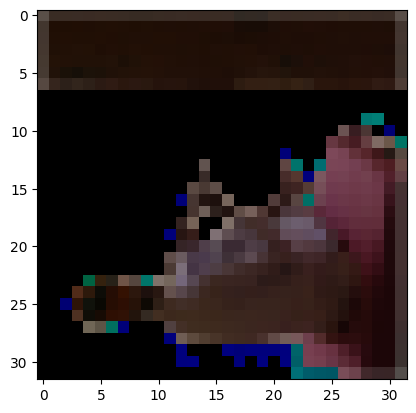

tensor(982, device='cuda:0')
tensor(356., device='cuda:0')
Accuracy of the network on the 10000 test images: 0 %


In [38]:
#model = model.eval()
from matplotlib import pyplot as plt

correct = 0
total = 0

with torch.no_grad():
    for data in ImageNetLoader:

        img, labels = data[0].to(device), data[1].to(device)
        outputs, hash_ = model(img)

        #print(labels)
        #print(outputs)
        
        target, predicted = torch.max(outputs.data, 1)

        #print(target)
        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        plt.imshow(img[0].cpu().type(torch.int8).T, interpolation='nearest')
        plt.show()

        print(predicted[0])
        print(labels[0])

        break;

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

### CuNN with ImageNet

In [39]:
from typing import List, Dict, Tuple

class cuNN:
    def __init__(self, size, hash_size, images, size_images ):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = np.zeros([len(images), hash_size ]).astype(np.float32)
        self.hash_size = hash_size
        self.images = images;
        self.size_ = size_images

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)

    def compute_hash(self):
        
        tensor_image = torch.FloatTensor(self.images).to("cuda:0")
        label, hash_ = model(tensor_image)
        signatures = torch.round(hash_).cpu().detach().numpy().astype(np.int8)
        
        idx = 0
        for signature in signatures:
            self.signatures[idx] = np.packbits( signature ).astype(np.float32)
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures
    
    def compute_candidate(self):
        candidate_pairs = set()

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                               tuple([hash_bucket[i], hash_bucket[j]])
                            )
        return candidate_pairs
    
    def check_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [43]:
IMAGES = images[0:5000].reshape(5000,3,32,32)
print(IMAGES.shape)

(5000, 3, 32, 32)


In [44]:
nnLSH = cuNN(16, 8, IMAGES, 5000)
signatures = nnLSH.compute_hash()

pairs = nnLSH.compute_candidate()

print(len(pairs))
duplicates = nnLSH.check_candidate(pairs, 0.9)
print(len(duplicates))

OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB. GPU 0 has a total capacity of 5.92 GiB of which 4.06 MiB is free. Process 8038 has 84.00 MiB memory in use. Process 59807 has 5.79 GiB memory in use. Of the allocated memory 5.63 GiB is allocated by PyTorch, and 85.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
num_row = 10
num_col = 6

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 2):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(IMAGES[duplicates[i//2 + idx_start][0]].astype(np.uint8).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels[duplicates[i//2 + idx_start][0]]}, {duplicates[i//2 + idx_start][0]}""")

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(IMAGES[duplicates[i//2 + idx_start][1]].astype(np.uint8).T)
    ax.set_title(f"""Label: {round(duplicates[i//2 + idx_start][2], 4)}, {labels[duplicates[i//2 + idx_start][1]]}, {duplicates[i//2 + idx_start][1]}""")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()